# Pricing Challenge


## Goal


The goal here is to evaluate whether a pricing test running on the site has been successful. User segmentation and providing insights about segments who behave differently as well as any other insights are the focuses of this project.


## Background


Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($39), while a random sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

1. Should the company sell its software for $39 or $59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import date, timedelta


import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
test = pd.read_csv('test_results.csv',parse_dates=['timestamp'])

In [3]:
user = pd.read_csv('user_table.csv')

In [4]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
df = pd.merge(user,test, how='outer')

In [7]:
df.head()

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted
0,510335,Peabody,USA,42.53,-70.97,2015-05-02 12:06:41,ads-google,mobile,android,0,39,0
1,89568,Reno,USA,39.54,-119.82,2015-04-30 16:02:01,ads_facebook,mobile,android,1,59,0
2,434134,Rialto,USA,34.11,-117.39,2015-05-16 19:53:40,direct_traffic,web,windows,1,59,0
3,289769,Carson City,USA,39.15,-119.74,2015-04-23 18:50:58,ads_facebook,web,windows,0,39,0
4,939586,Chicago,USA,41.84,-87.68,2015-03-08 13:53:10,ads_facebook,mobile,iOS,1,59,0


In [8]:
df.describe()

,user_id,lat,long,test,price,converted
count,316800.000000,275616.000000,275616.000000,316800.000000,316800.000000,316800.000000
mean,499281.341840,37.111680,-93.981772,0.360079,46.205051,0.018333
std,288591.154044,5.209627,18.086486,0.480024,9.601487,0.134154
min,3.000000,19.700000,-157.800000,0.000000,39.000000,0.000000
25%,249525.750000,33.660000,-112.200000,0.000000,39.000000,0.000000
50%,499021.500000,37.740000,-88.930000,0.000000,39.000000,0.000000
75%,749025.500000,40.700000,-78.910000,1.000000,59.000000,0.000000
max,1000000.000000,61.180000,30.310000,1.000000,59.000000,1.000000


In [93]:
def mean_count(dt,group_var,target_var):
    mean = pd.DataFrame(dt.groupby(group_var)[target_var].mean()).reset_index()
    mean.columns = [group_var,'mean']
    count = pd.DataFrame(dt.groupby(group_var)[target_var].count()).reset_index()
    count.columns = [group_var,'count']
    mc = pd.merge(left=mean,right=count, left_on=group_var, right_on=group_var)
    return mc
def mc_plot(df,groupvar):
    fig, ax = plt.subplots(figsize=(16,4))
    sns.lineplot(x=df[groupvar], 
                 y=df['mean'],
                 color='r',
                 ax=ax)
    sns.lineplot(x=df[groupvar], 
                 y=df['count'], 
                 color='b',
                 ax=ax)    
    ax.legend(['mean', 'count'], facecolor='w')
    plt.show()

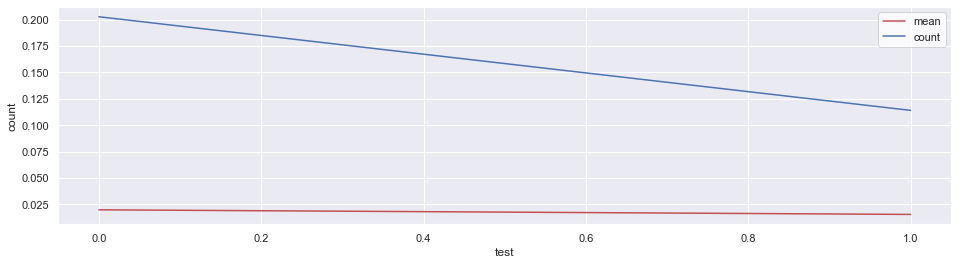

In [97]:
test_mc = mean_count(df,group_var='test',target_var='converted')
test_mc['count'] = test_mc['count'] /10**6
mc_plot(test_mc,groupvar = 'test')

In [89]:
def plot_bin(var,df,bin_number):
    sns.set(rc={'figure.figsize':(10,4)})
    var_df = pd.DataFrame(df[var].value_counts(bins = bin_number,normalize=True,sort=False,dropna=False))
    var_df[var] = np.hstack(var_df.values)
    var_df['mid'] = var_df.index.mid.map(lambda x : round(x,2))
    # lat_df['lat_left'] = lat_df.index.left
    # lat_df['lat_right'] = lat_df.index.right
    # lat_df['interval'] = lat_df['lat_right']-lat_df['lat_left']
    var_df.columns = ['count_percent','mid_point']
    sns.barplot(data=var_df, y='count_percent', x='mid_point').set_title(var)

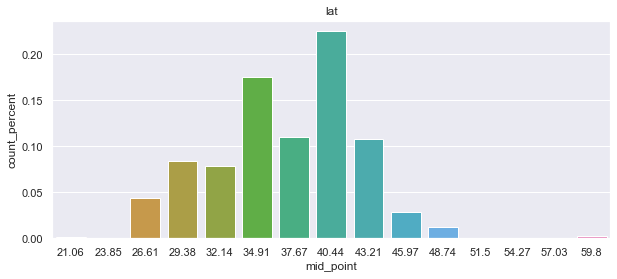

In [90]:
plot_bin(var='lat',df=df,bin_number=15)

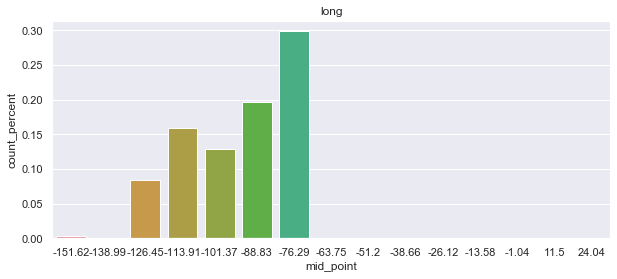

In [91]:
plot_bin(var='long',df=df,bin_number=15)